In [1]:
%load_ext autoreload
%autoreload 2

In [42]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import minimize_scalar, minimize
from time import time
import seaborn as sns
import cvxpy as cxv
sns.set_style('darkgrid')
sns.set_context('notebook')
import sys
sys.path.append('..')

In [3]:
from osd import Problem
from osd.components import GaussNoise, SmoothFirstDifference, SparseFirstDiffConvex, Boolean, MarkovChain
from osd.utilities import progress
import cvxpy as cvx

In [4]:
from admm_helpers import markov_process_simulator, run_admm

# Convex example, $K=3$

In [5]:
def proj_l2_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(y) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d0(data, theta=1, c=1):
    """Sum of squares"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(y)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d1(data, theta=1, c=1):
    """Sum of absolute value of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=1))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l1_d2(data, theta=1, c=1):
    """Sum of absolute value of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum(cvx.abs(cvx.diff(y, k=2))) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d2(data, theta=1, c=1):
    """Sum of squares of second difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=2)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def proj_l2_d1(data, theta=1, c=1):
    """Sum of squares of first difference"""
    x = data
    y = cvx.Variable(len(x))
    cost = cvx.sum_squares(x - y)
    objective = cvx.Minimize(cost)
    constraints = [theta * cvx.sum_squares(cvx.diff(y, k=1)) <= c]
    problem = cvx.Problem(objective, constraints)
    problem.solve(solver='MOSEK')
    return y.value

def make_data(length, points=None, shifts=None):
    if points is None:
        points = [0, int(length * 0.2), int(length * 0.55), int(length * 0.85), length]
    if shifts is None:
        shifts = [0, .5, -0.75, .2]
    cp = np.zeros(length)
    for ix, shft in enumerate(shifts):
        a = points[ix]
        b = points[ix + 1]
        cp[a:b] = shft
    return cp

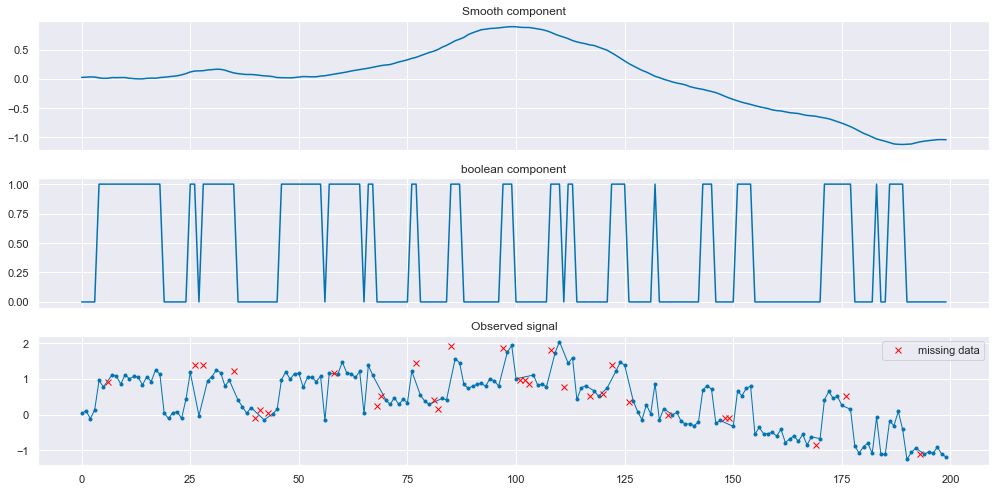

In [7]:
np.random.seed(4)
T = 200
p = 0.2
X_real = np.zeros((3, T))
X_real[0] = 0.15 * np.random.randn(T)
X_real[1] = 5 * proj_l2_d1(np.random.randn(T), theta=3e2)
X_real[1] -= np.average(X_real[1])
X_real[2] = markov_process_simulator([[1-p, p], [p, 1-p]], T=T, plot=False)
y = np.sum(X_real, axis=0)
np.random.seed(25)
remove_ix = np.random.choice(np.arange(len(y)), int(len(y) * 0.15), replace=False)
remove_ix.sort()
use_ix = np.ones_like(y, dtype=bool)
use_ix[remove_ix] = False

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(14, 7))
ax[0].set_title('Smooth component')
ax[0].plot(X_real[1])
ax[1].set_title('boolean component')
ax[1].plot(X_real[2])
ax[2].set_title('Observed signal')
ax[2].plot(np.arange(T)[use_ix], y[use_ix], linewidth=1, marker='.')
ax[2].plot(np.arange(T)[~use_ix], y[~use_ix], linewidth=1, marker='x', color='red', ls='none', label='missing data')
ax[2].legend()
# ax[2].plot(signal1 + signal2, label='true signal minus noise', ls='--')
plt.tight_layout()
plt.show()


In [29]:
lambda2 = 1.27e+01
lambda3 = 2.5e-01
# lambda2 = 1e1
# lambda3 = 5e3
c1 = GaussNoise()
c2 = SmoothFirstDifference(theta=lambda2)
p = 0.25
c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=lambda3)
components = [c1, c2, c3]

In [30]:
problem = Problem(y, components)

In [31]:
problem.decompose(admm=True, rho=1, num_iter=100) #, use_set=use_ix)
sos = np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~use_ix], 2))
sae = np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~use_ix]))
print('sos: {:.2f}, sae: {:.2f}'.format(sos, sae))

[============================================================] 100.0% ...1.54 sec
sos: 0.00, sae: 0.00


In [395]:
problem.decompose(admm=True, rho=1, num_iter=100, use_set=use_ix)
sos = np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~use_ix], 2))
sae = np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~use_ix]))
print('sos: {:.2f}, sae: {:.2f}'.format(sos, sae))

[============================================================] 100.0% ...1.35 sec
sos: 18.49, sae: 35.44


In [377]:
ylim = (-0.65, 1.2)

NameError: name 'ylim' is not defined

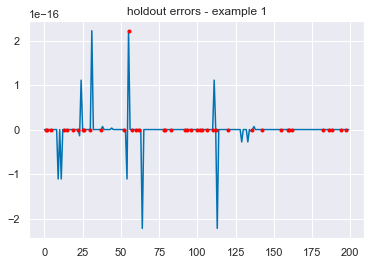

In [27]:
plt.plot((y - np.sum(problem.estimates, axis=0)))
plt.plot(np.arange(len(y))[~use_ix], (y - np.sum(problem.estimates, axis=0))[~use_ix], color='red', marker='.', ls='none')
plt.title('holdout errors - example 1')
plt.ylim(*ylim)

(-0.65, 1.2)

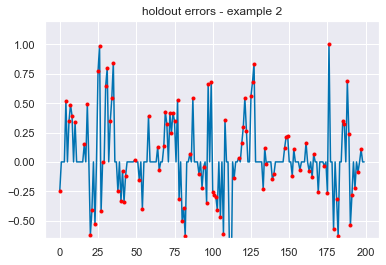

In [396]:
plt.plot((y - np.sum(problem.estimates, axis=0)))
plt.plot(np.arange(len(y))[~use_ix], (y - np.sum(problem.estimates, axis=0))[~use_ix], color='red', marker='.', ls='none')
plt.title('holdout errors - example 2')
plt.ylim(*ylim)

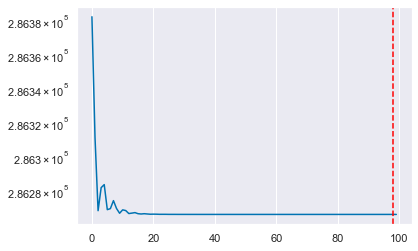

In [317]:
plt.plot(problem.admm_result['obj_vals'])
plt.axvline(problem.admm_result['it'], color='red', ls='--')
plt.yscale('log')

In [318]:
# import matplotlib
# sns.set_context('paper')
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })


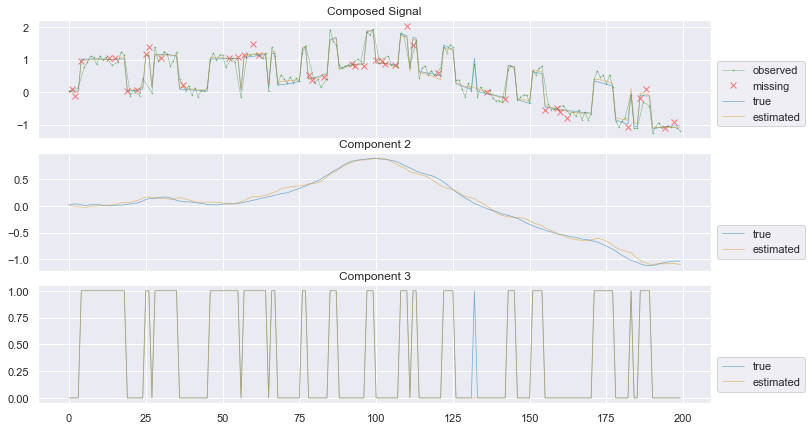

In [32]:
K = len(components)
fs = np.array([5.5,2.9])
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=2*fs)
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(est, label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Component {}'.format(k+1))
    else:
        ax[k].plot(
            np.arange(T)[use_ix],
            np.sum(X_real, axis=0)[use_ix], 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1, alpha=0.5
        )
        ax[k].plot(
            np.arange(T)[~use_ix],
            np.sum(X_real, axis=0)[~use_ix], 
            label='missing', marker='x', color='red', ls='none', alpha=0.5
        )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Composed Signal')
    ax[k].legend(loc=[1.01, 0.1])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example.pgf')

In [8]:
K = len(components)
fig, ax = plt.subplots(nrows=K+1, sharex=True, figsize=(5.5,2.9))
for k in range(K+1):
    if k <= K-1:
        ax[k].plot(X_real[k], linewidth=0.75)
        ax[k].set_title('component {}'.format(k+1))
    else:
        ax[k].plot(np.arange(T)[use_ix], y[use_ix], linewidth=1, marker='.', ms=2)
        ax[k].plot(np.arange(T)[~use_ix], y[~use_ix], linewidth=1, marker='x', ms=3,
                   color='red', ls='none', label='missing data', alpha=0.6)
        ax[k].set_title('observed, $y$')
        ax[k].legend(loc=(1.01, 0.2))
        
ax[1].set_ylim(-1.25, 1.25)
ax[3].set_ylim(-2, 2)
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/example-components.pgf')
plt.show()

NameError: name 'components' is not defined

In [21]:
~np.all(np.isclose(np.diff(problem.estimates[-1]), 0))

False

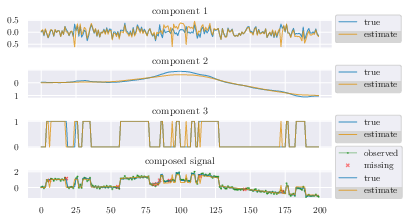

In [209]:
K = len(components)
fig, ax = plt.subplots(nrows=K+1, sharex=True, figsize=(5.5,2.9))
for k in range(K+1):
    if k <= K-1:
        ax[k].plot(X_real[k], linewidth=0.75, label='true', alpha=0.75)
        ax[k].plot(problem.estimates[k], label='estimate', linewidth=0.75, alpha=0.75)
        ax[k].set_title('component {}'.format(k+1))
        ax[k].legend(loc=[1.01, 0.2])
    else:
        ax[k].plot(
            np.arange(T)[use_ix],
            np.sum(X_real, axis=0)[use_ix], 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1.5, alpha=0.5
        )
        ax[k].plot(
            np.arange(T)[~use_ix],
            np.sum(X_real, axis=0)[~use_ix], 
            label='missing', marker='x', color='red', ls='none', alpha=0.5, ms=3
        )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.75)
        ax[k].plot(problem.estimates[1] + problem.estimates[2], label='estimate', 
                   linewidth=0.75, alpha=0.75)
        ax[k].set_title('composed signal')
        ax[k].legend(loc=[1.01, 0.0])
plt.tight_layout(pad=0.05)
fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example-bad.pgf')

In [11]:
# l2s = np.logspace(0,3,20)
# l3s = np.logspace(-1,0.5,20)
# num_splits = 20
# hold = 0.2
# splits = []
# for s in range(num_splits):
#     remove_ix = np.random.choice(np.arange(len(y)), int(len(y) * hold), replace=False)
#     remove_ix.sort()
#     use_ix = np.ones_like(y, dtype=bool)
#     use_ix[remove_ix] = False
#     splits.append(use_ix)

# l2_errors = np.zeros((len(l3s), len(l2s)))
# l1_errors = np.zeros((len(l3s), len(l2s)))
# count_switches = np.zeros((len(l3s), len(l2s)))
# smoothness = np.zeros((len(l3s), len(l2s)))
# counter = 0
# for j, l2 in enumerate(l2s):
#     for i, l3 in enumerate(l3s):
#         progress(counter, l2_errors.size)
#         c1 = GaussNoise()
#         c2 = SmoothFirstDifference(theta=l2)
#         p = 0.25
#         c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=l3)
#         components = [c1, c2, c3]
#         problem = Problem(y, components)
#         sos = 0
#         sae = 0
#         smth = 0
#         count_sw = 0
#         for uix in splits:
#                 problem.decompose(admm=True, rho=1, num_iter=100, use_set=uix, verbose=False)
# #                 print(np.sum(np.power((y - np.sum(problem.estimates, axis=0))[test_ix], 2)))
#                 sos += np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~uix], 2))
#                 sae += np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~uix]))
#                 smth =+ np.sum(np.power(np.diff(problem.estimates[1]), 2))
#                 count_sw +=np.sum(~np.isclose(np.diff(problem.estimates[-1]), 0))
#         l2_errors[i, j] = sos / (num_splits * np.sum(~uix))
#         l1_errors[i, j] = sae / (num_splits * np.sum(~uix))
#         smoothness[i, j] = smth / (num_splits)
#         count_switches[i, j] = count_sw / (num_splits)
#         counter += 1
# progress(counter, l2_errors.size)
# run3 = {
#     'l2': np.copy(l2s),
#     'l3': np.copy(l3s),
#     'sos': np.copy(l2_errors),
#     'sae': np.copy(l1_errors),
#     'smoothness': np.copy(smoothness),
#     'switches': np.copy(count_switches)
# }
# with open('validation_run_3.pkl', 'wb') as f:
#     pickle.dump(run3, f)

fuck! i accidentially overwrote the file from the other notebook... damnit...

In [47]:
with open('validation_run_3.pkl', 'rb') as f:
    run3 = pickle.load(f)

l2s = run3['l2']
l3s = run3['l3']

In [48]:
f2 = interp1d(l2s, np.arange(len(l2s)))
f3 = interp1d(l3s, np.arange(len(l3s)))
xticks = [f2(i).item() for i in np.logspace(0, 3, 4)]
yticks = [f3(i).item() for i in np.logspace(-1, 0, 2)]
xticklabels = ['$10^{}$'.format(i) for i in range(4)]
yticklabels = ['$10^{-1}$', '$10^{0}$']

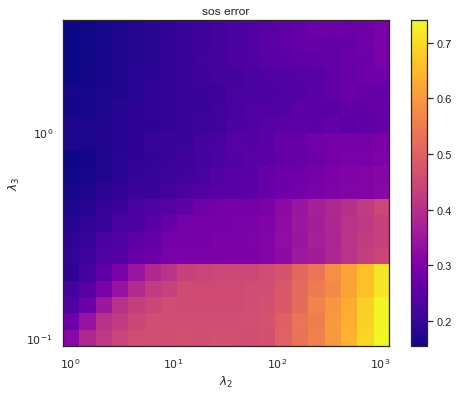

<Figure size 432x288 with 0 Axes>

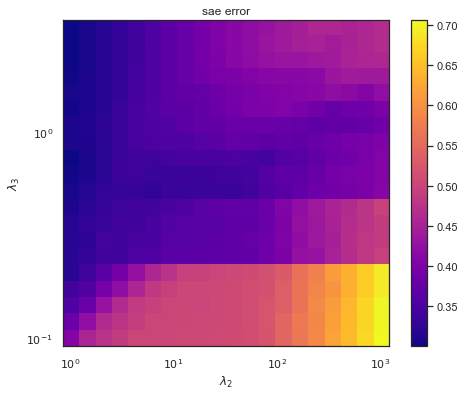

<Figure size 432x288 with 0 Axes>

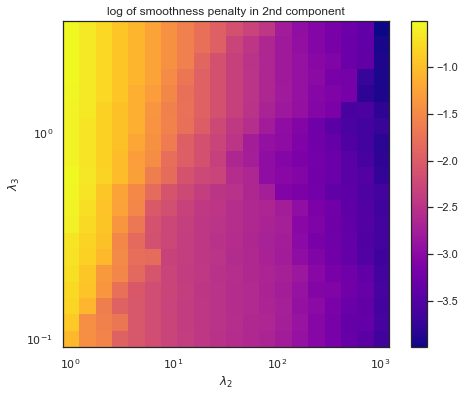

<Figure size 432x288 with 0 Axes>

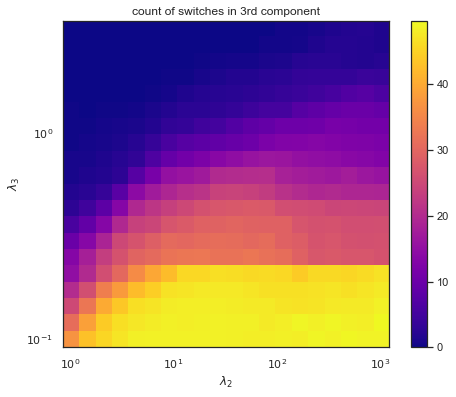

In [50]:
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run3['sos'], cmap='plasma')
    plt.colorbar(cp)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sos error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run3['sae'], cmap='plasma')
    plt.colorbar(cp)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sae error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(np.log10(run3['smoothness']), cmap='plasma')
    plt.colorbar(cp)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('log of smoothness penalty in 2nd component');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run3['switches'], cmap='plasma')
    plt.colorbar(cp)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('count of switches in 3rd component');

In [51]:
X, Y = np.meshgrid(run3['l2'], run3['l3'])
msk = X >= 5
i_best = np.argmin(run3['sae'][msk])
print(
    X[msk][i_best],
    Y[msk][i_best],
    run2['sae'][msk][i_best]
)

6.158482110660264 0.5134832907437552 0.32609339902022344


<Figure size 432x288 with 0 Axes>

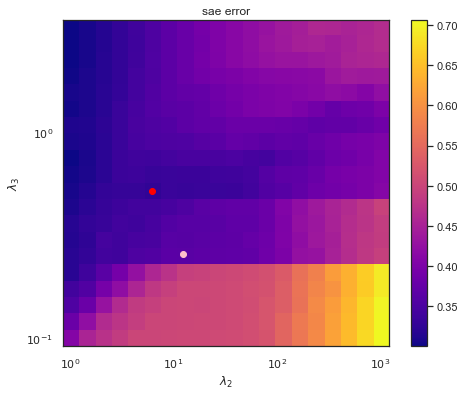

<Figure size 432x288 with 0 Axes>

In [57]:
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run3['sae'], cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(X[msk][i_best]), f3(Y[msk][i_best]), color='red')
    ax.scatter(f2(X[msk][i_best]*2), f3(Y[msk][i_best]*0.5), color='pink')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sae error');
plt.figure()

In [ ]:
plt.plot(Y[0, ])

In [54]:
lambda2 = X[msk][i_best] * 2
lambda3 = Y[msk][i_best] * 0.5

c1 = GaussNoise()
c2 = SmoothFirstDifference(theta=lambda2)
p = 0.25
c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=lambda3)
components = [c1, c2, c3]

problem = Problem(y, components)
problem.decompose(admm=True, rho=1, num_iter=100)#, use_set=use_ix)
sos = np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~use_ix], 2))
sae = np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~use_ix]))
print('sos: {:.2f}, sae: {:.2f}'.format(sos, sae))

[============================================================] 100.0% ...1.42 sec
sos: 0.00, sae: 0.00


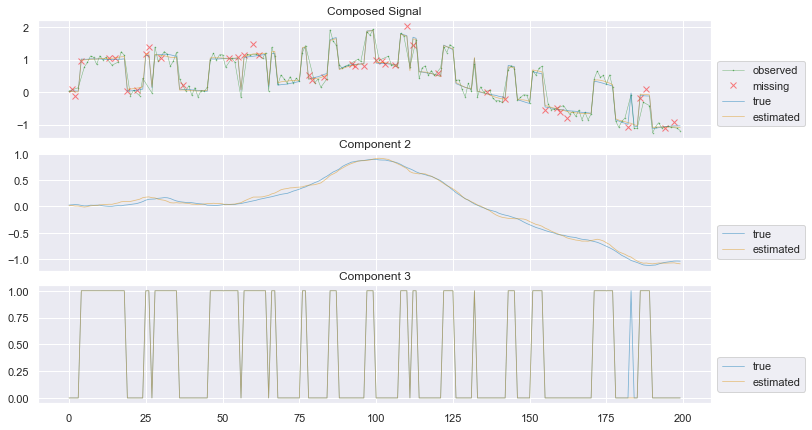

In [55]:
K = len(components)
fs = np.array([5.5,2.9])
fig, ax = plt.subplots(nrows=K, sharex=True, figsize=2*fs)
for k in range(K):
    if k > 0:
        true = X_real[k]
        est = problem.estimates[k]
        ax[k].plot(true, label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(est, label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Component {}'.format(k+1))
    else:
        ax[k].plot(
            np.arange(T)[use_ix],
            np.sum(X_real, axis=0)[use_ix], 
            label='observed', linewidth=0.5, marker='.', color='green', ms=1, alpha=0.5
        )
        ax[k].plot(
            np.arange(T)[~use_ix],
            np.sum(X_real, axis=0)[~use_ix], 
            label='missing', marker='x', color='red', ls='none', alpha=0.5
        )
        ax[k].plot(np.sum(X_real[1:], axis=0), label='true', linewidth=0.75, alpha=0.5)
        ax[k].plot(np.sum(problem.estimates[1:], axis=0), label='estimated', linewidth=0.75, alpha=0.5)
        ax[k].set_title('Composed Signal')
    ax[k].legend(loc=[1.01, 0.1])
plt.tight_layout(pad=0.05)
# fig.savefig('/Users/bennetmeyers/Documents/Boyd-work/OSD-presentations/April2021/figs/simple-example.pgf')

In [75]:
np.logspace(np.log10(2), np.log10(2000), 10)

array([2.00000000e+00, 4.30886938e+00, 9.28317767e+00, 2.00000000e+01,
       4.30886938e+01, 9.28317767e+01, 2.00000000e+02, 4.30886938e+02,
       9.28317767e+02, 2.00000000e+03])

In [76]:
l2s = np.logspace(0, 2, 10)
l3s = np.logspace(-1, 1, 10)
num_splits = 12
hold = 0.1
splits = []
for s in range(num_splits):
    remove_ix = np.random.choice(np.arange(len(y)), int(len(y) * hold), replace=False)
    remove_ix.sort()
    use_ix = np.ones_like(y, dtype=bool)
    use_ix[remove_ix] = False
    splits.append(use_ix)

l2_errors = np.zeros((len(l3s), len(l2s)))
l1_errors = np.zeros((len(l3s), len(l2s)))
count_switches = np.zeros((len(l3s), len(l2s)))
smoothness = np.zeros((len(l3s), len(l2s)))
counter = 0
for j, l2 in enumerate(l2s):
    for i, l3 in enumerate(l3s):
        progress(counter, l2_errors.size)
        c1 = GaussNoise()
        c2 = SmoothFirstDifference(theta=l2)
        p = 0.25
        c3 = MarkovChain([[1-p, p], [p, 1-p]], theta=l3)
        components = [c1, c2, c3]
        problem = Problem(y, components)
        sos = 0
        sae = 0
        smth = 0
        count_sw = 0
        for uix in splits:
                problem.decompose(admm=True, rho=1, num_iter=100, use_set=uix, verbose=False)
#                 print(np.sum(np.power((y - np.sum(problem.estimates, axis=0))[test_ix], 2)))
                sos += np.sum(np.power((y - np.sum(problem.estimates, axis=0))[~uix], 2))
                sae += np.sum(np.abs((y - np.sum(problem.estimates, axis=0))[~uix]))
                smth =+ np.sum(np.power(np.diff(problem.estimates[1]), 2))
                count_sw +=np.sum(~np.isclose(np.diff(problem.estimates[-1]), 0))
        l2_errors[i, j] = sos / (num_splits * np.sum(~uix))
        l1_errors[i, j] = sae / (num_splits * np.sum(~uix))
        smoothness[i, j] = smth / (num_splits)
        count_switches[i, j] = count_sw / (num_splits)
        counter += 1
progress(counter, l2_errors.size)
run5 = {
    'l2': np.copy(l2s),
    'l3': np.copy(l3s),
    'sos': np.copy(l2_errors),
    'sae': np.copy(l1_errors),
    'smoothness': np.copy(smoothness),
    'switches': np.copy(count_switches)
}
with open('validation_run_5.pkl', 'wb') as f:
    pickle.dump(run5, f)

In [68]:
with open('validation_run_5.pkl', 'rb') as f:
    run5 = pickle.load(f)

In [96]:
f2 = interp1d(run5['l2'], np.arange(len(run5['l2'])))
f3 = interp1d(run5['l3'], np.arange(len(run5['l3'])))
xticks = [f2(i).item() for i in np.logspace(0, 2, 3)]
yticks = [f3(i).item() for i in np.logspace(-1, 1, 3)]
xticklabels = ['$10^{'+'{}'.format(i + 1)+'}$' for i in range(len(xticks))]
xticklabels = ['$10^{'+'{}'.format(i + 1)+'}$' for i in range(len(xticks))]
# yticklabels = [.5, 1]
yticklabels = ['$10^{'+'{}'.format(i - 1)+'}$' for i in range(len(yticks))]

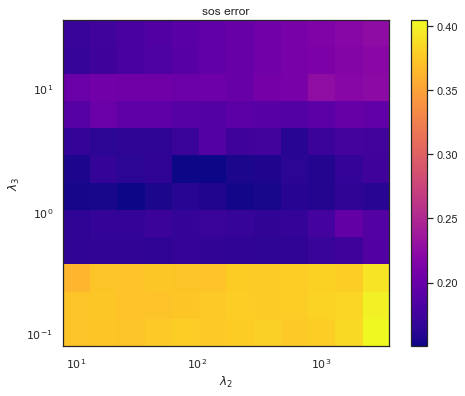

<Figure size 432x288 with 0 Axes>

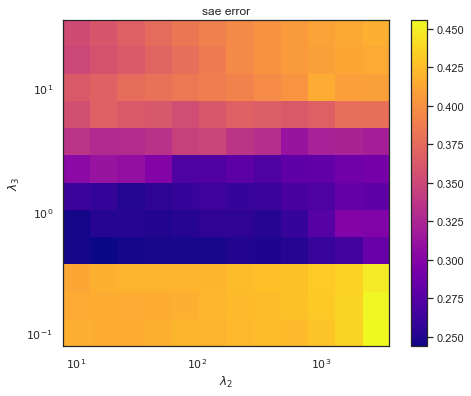

<Figure size 432x288 with 0 Axes>

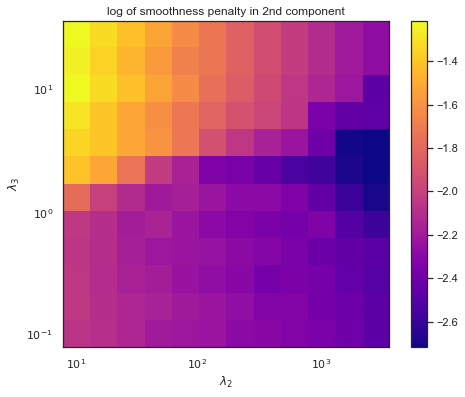

<Figure size 432x288 with 0 Axes>

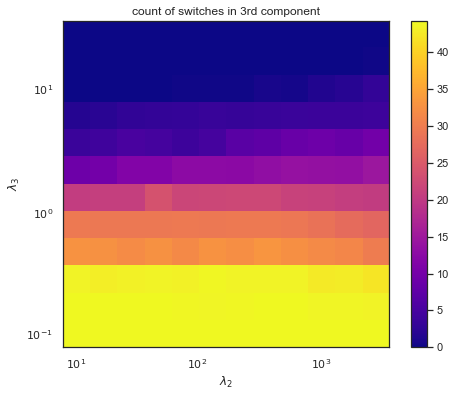

In [97]:
i = 10
j = 7
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run4['sos'], cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sos error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run4['sae'], cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sae error');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(np.log10(run4['smoothness']), cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('log of smoothness penalty in 2nd component');
plt.figure()
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    cp = ax.imshow(run4['switches'], cmap='plasma')
    plt.colorbar(cp)
#     ax.scatter(f2(l2s[j]), f3(l3s[i]), color='red')
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('count of switches in 3rd component');

In [98]:
X, Y = np.meshgrid(run5['l2'], run5['l3'])
msk = run5['switches'] >= 1
i_best = np.argmin(run5['sae'][msk])
print(
    X[msk][i_best],
    Y[msk][i_best],
    run5['sae'][msk][i_best]
)

1.0 0.774263682681127 0.283023455035047


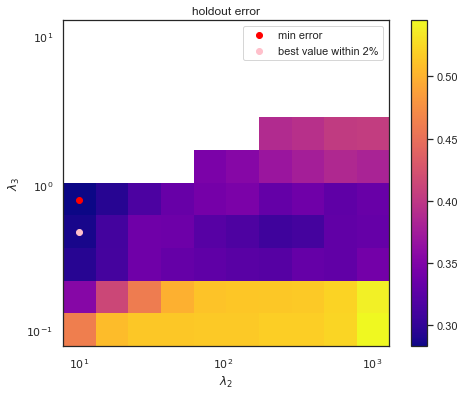

In [101]:
slct = run5['sae'] <= run5['sae'].ravel()[i_best]*1.02
best_lambda2 = np.max(X[slct])
best_lambda3 = np.min(Y[slct])
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    im = np.copy(run5['sae'])
    im[~msk] = np.nan
    cp = ax.imshow(im, cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(X.ravel()[i_best]), f3( Y.ravel()[i_best]), color='red', label='min error')
    ax.scatter(f2(best_lambda2), f3(best_lambda3), color='pink', label='best value within 2%')
    ax.legend()
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('holdout error');

In [92]:
X, Y = np.meshgrid(run5['l2'], run5['l3'])
msk = run5['switches'] >= 1
i_best = np.argmin(run5['sos'][msk])
print(
    X[msk][i_best],
    Y[msk][i_best],
    run5['sos'][msk][i_best]
)

1.0 0.774263682681127 0.14313078499690565


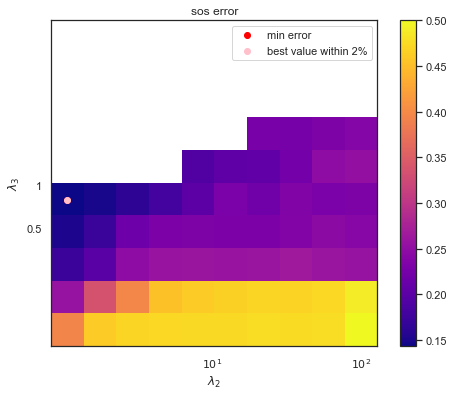

In [94]:
slct = run5['sos'] <= run5['sos'].ravel()[i_best]*1.025
best_lambda2 = np.max(X[slct])
best_lambda3 = np.min(Y[slct])
with sns.axes_style('white'):
    fig,ax=plt.subplots(1,1, figsize=(8,6))
    im = np.copy(run5['sos'])
    im[~msk] = np.nan
    cp = ax.imshow(im, cmap='plasma')
    plt.colorbar(cp)
    ax.scatter(f2(X.ravel()[i_best]), f3( Y.ravel()[i_best]), color='red', label='min error')
    ax.scatter(f2(best_lambda2), f3(best_lambda3), color='pink', label='best value within 2%')
    ax.legend()
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.invert_yaxis()
    plt.xlabel('$\lambda_2$')
    plt.ylabel('$\lambda_3$')
    plt.title('sos error');